In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import argparse
import sys
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

import influence
from mnist_convnet import deepnn

np.random.seed(1)

def corrupt_mnist(mnist, corrupt_prob):
    assert corrupt_prob >= 0 and corrupt_prob <= 1, "this is not a valid corruption probability"
    size = len(mnist.train.labels)
    float_mask = np.random.random([size])
    mnist.train.corrupted_mask = np.less(float_mask, corrupt_prob)
    mnist.train.original_labels = mnist.train.labels.copy()
    for i in range(size):
        if mnist.train.corrupted_mask[i] == True:            
            corrupted_label = np.random.randint(9)
            if np.argmax(mnist.train.labels[i]) == corrupted_label:
                corrupted_label = 9
            #corrupted_label = 0   
            
            mnist.train.labels[i] = np.zeros([10])
            mnist.train.labels[i][corrupted_label] = 1
    return mnist

FLAGS = None

# Import data
mnist = corrupt_mnist(input_data.read_data_sets("mnist_data", one_hot=True), 0.03)

# Create the model
with tf.name_scope("net"):
    input_ph = tf.placeholder(tf.float32, [None, 784])
    y = deepnn(input_ph)

# Define loss and optimizer
with tf.name_scope("loss"):
    y_ = tf.placeholder(tf.float32, [None, 10], name="y_target")
    batch_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    cross_entropy = tf.reduce_mean(batch_loss)

lr = tf.Variable(0.1)
opt = tf.train.AdamOptimizer(lr)
grads_and_vars = opt.compute_gradients(cross_entropy)
train_step = opt.apply_gradients(grads_and_vars)

# Test trained model
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
#saver.restore(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

summary_writter = tf.summary.FileWriter("./Hvp_summaries", sess.graph)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [2]:
test_feed_dic = {input_ph: mnist.test.images, y_: mnist.test.labels}

batch_xs, batch_ys = mnist.train.next_batch(mnist.test.images.shape[0])
train_feed_dic = {input_ph:batch_xs, y_:batch_ys}

testset = (mnist.test.images, mnist.test.labels)
#Hv_trainset_size = mnist.test.images.shape[0]
Hv_trainset_size = 10000
Hv_trainset = mnist.train.next_batch(Hv_trainset_size)

In [3]:
gs = [g for g,v in grads_and_vars if g is not None]

In [31]:
inf = influence.Influence(cross_entropy, input_ph, y_, testset, Hv_trainset, grads=gs, cg_iters = 50, dampening=5e-1, vervose=1)

error: 0.30837
- iter: 0
Error: 0.324278905046
- iter: 1
Error: 0.215200268226
- iter: 2
Error: 0.12904318457
- iter: 3
Error: 0.0857886383745
- iter: 4
Error: 0.054578827261
- iter: 5
Error: 0.035950309499
- iter: 6
Error: 0.0233712253255
- iter: 7
Error: 0.0123431615254
- iter: 8
Error: 0.00993452211747
- iter: 9
Error: 0.00638106336196
- iter: 10
Error: 0.0047872017236
- iter: 11
Error: 0.00324520957717
- iter: 12
Error: 0.00214938065726
- iter: 13
Error: 0.0014658715665
- iter: 14
Error: 0.000921154745499
- iter: 15
Error: 0.000673519266973
- iter: 16
Error: 0.000447207325206
- iter: 17
Error: 0.000298425243935
- iter: 18
Error: 0.000279925524222
- iter: 19
Error: 0.000164314565867
- iter: 20
Error: 0.000101179114651
- iter: 21
Error: 5.72298379247e-05
- iter: 22
Error: 3.42553245852e-05
- iter: 23
Error: 2.74934271873e-05
- iter: 24
Error: 1.86187992146e-05
- iter: 25
Error: 1.13666336705e-05
- iter: 26
Error: 6.75446322914e-06
- iter: 27
Error: 4.6468729622e-06
- iter: 28
Error: 

In [32]:
influences_corrupted = []
influences_non_corrupted = []
#size = len(mnist.train.labels)
size = 1000
for i in range(size):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ = inf.of(z)
    if mnist.train.corrupted_mask[i]:
        influences_corrupted.append(influ)
    else:
        influences_non_corrupted.append(influ)
all_influences = influences_corrupted + influences_non_corrupted

In [25]:
print("non corrupted")
print("mean",np.mean( influences_non_corrupted))
print("std",np.std( influences_non_corrupted))

non corrupted
mean -3.61476422059e-06
std 3.3820495475e-05


In [26]:
print("corrupted")
print("mean",np.mean( influences_corrupted))
print("std",np.std( influences_corrupted))

corrupted
mean 4.13055946568e-06
std 7.22604729255e-05


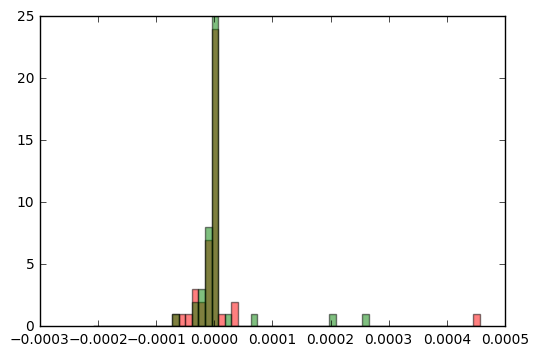

In [30]:
bins = np.linspace(min(all_influences), max(all_influences), 60)
sub_non_corrupted = influences_non_corrupted[0:len(influences_corrupted)]
matplotlib.pyplot.hist(influences_corrupted, bins, alpha=0.5, label='x', color="red")
matplotlib.pyplot.hist(sub_non_corrupted, bins, alpha=0.5, label='y', color="green")
matplotlib.pyplot.show()

296
296
9704
0.0 1.30545
[ 0.          0.03347301  0.06694601  0.10041902  0.13389202  0.16736503
  0.20083803  0.23431104  0.26778405  0.30125705  0.33473006  0.36820306
  0.40167607  0.43514907  0.46862208  0.50209508  0.53556809  0.5690411
  0.6025141   0.63598711  0.66946011  0.70293312  0.73640612  0.76987913
  0.80335214  0.83682514  0.87029815  0.90377115  0.93724416  0.97071716
  1.00419017  1.03766318  1.07113618  1.10460919  1.13808219  1.1715552
  1.2050282   1.23850121  1.27197422  1.30544722]


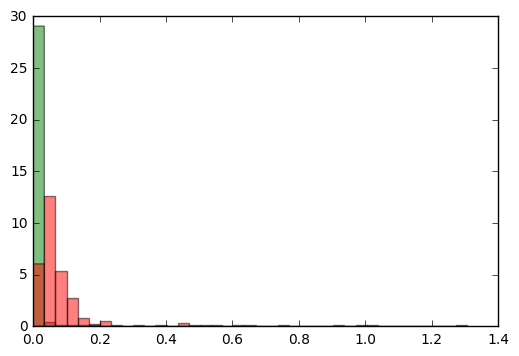

avrg corrupted loss: 0.0932193672115
avrg non corrupted loss: 0.0041527402368


In [47]:
b_loss_np = sess.run(batch_loss, train_feed_dic)
corrupted_loss = 0
corrupted_count = 0
non_corrupted_loss = 0
corrupted_grad_list = []
non_corrupted_grad_list = []
for i in range(len(b_loss_np)):
    if mnist.train.corrupted_mask[i] == True:
        corrupted_loss += b_loss_np[i]
        corrupted_grad_list.append(b_loss_np[i])
        corrupted_count += 1
    else:
        non_corrupted_loss += b_loss_np[i]
        non_corrupted_grad_list.append(b_loss_np[i])
        
non_corrupted_count = len(b_loss_np) - corrupted_count

sub_non_corrupted = non_corrupted_grad_list[0:len(corrupted_grad_list)]
print(len(sub_non_corrupted))
print(len(corrupted_grad_list))
print(len(non_corrupted_grad_list))
print(min(b_loss_np), max(b_loss_np))
bins = np.linspace(min(b_loss_np), max(b_loss_np), 40)
print(bins)
matplotlib.pyplot.hist(sub_non_corrupted, bins, alpha=0.5, label='y', color="green", normed=True)[1]
matplotlib.pyplot.hist(corrupted_grad_list, bins, alpha=0.5, label='x', color="red", normed=True)[1]
matplotlib.pyplot.show()

print("avrg corrupted loss:", corrupted_loss/corrupted_count)
print("avrg non corrupted loss:", non_corrupted_loss/non_corrupted_count)

296
296
9704
0.0 3.79885
[ 0.2         0.24555509  0.29111019  0.33666528  0.38222038  0.42777547
  0.47333057  0.51888566  0.56444075  0.60999585  0.65555094  0.70110604
  0.74666113  0.79221622  0.83777132  0.88332641  0.92888151  0.9744366
  1.0199917   1.06554679  1.11110188  1.15665698  1.20221207  1.24776717
  1.29332226  1.33887736  1.38443245  1.42998754  1.47554264  1.52109773
  1.56665283  1.61220792  1.65776302  1.70331811  1.7488732   1.7944283
  1.83998339  1.88553849  1.93109358  1.97664867  2.02220377  2.06775886
  2.11331396  2.15886905  2.20442415  2.24997924  2.29553433  2.34108943
  2.38664452  2.43219962  2.47775471  2.52330981  2.5688649   2.61441999
  2.65997509  2.70553018  2.75108528  2.79664037  2.84219546  2.88775056
  2.93330565  2.97886075  3.02441584  3.06997094  3.11552603  3.16108112
  3.20663622  3.25219131  3.29774641  3.3433015   3.3888566   3.43441169
  3.47996678  3.52552188  3.57107697  3.61663207  3.66218716  3.70774226
  3.75329735  3.79885244]


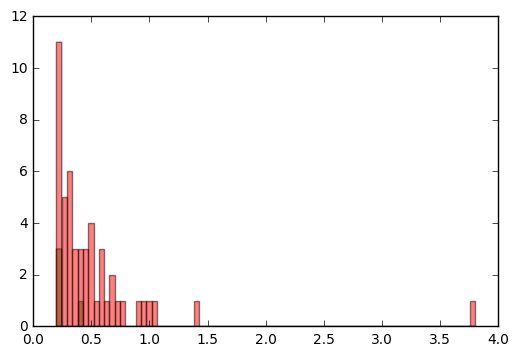

avrg corrupted loss: 0.140657840519
avrg non corrupted loss: 0.00885041745615


In [23]:
b_loss_np = sess.run(batch_loss, train_feed_dic)
corrupted_loss = 0
corrupted_count = 0
non_corrupted_loss = 0
corrupted_grad_list = []
non_corrupted_grad_list = []
for i in range(len(b_loss_np)):
    if mnist.train.corrupted_mask[i] == True:
        corrupted_loss += b_loss_np[i]
        corrupted_grad_list.append(b_loss_np[i])
        corrupted_count += 1
    else:
        non_corrupted_loss += b_loss_np[i]
        non_corrupted_grad_list.append(b_loss_np[i])
        
non_corrupted_count = len(b_loss_np) - corrupted_count

sub_non_corrupted = non_corrupted_grad_list[0:len(corrupted_grad_list)]
print(len(sub_non_corrupted))
print(len(corrupted_grad_list))
print(len(non_corrupted_grad_list))
print(min(b_loss_np), max(b_loss_np))
bins = np.linspace(min(b_loss_np)+0.2, max(b_loss_np), 80)
print(bins)
non_c_hist = matplotlib.pyplot.hist(sub_non_corrupted, bins, alpha=0.5, label='y', color="green", normed=False)[0]
c_hist = matplotlib.pyplot.hist(corrupted_grad_list, bins, alpha=0.5, label='x', color="red", normed=False)[0]
matplotlib.pyplot.show()

print("avrg corrupted loss:", corrupted_loss/corrupted_count)
print("avrg non corrupted loss:", non_corrupted_loss/non_corrupted_count)

In [20]:
ratio = non_c_hist/c_hist

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [5]:
def train(n, learning_rate=0.1e-4):
    sess.run(tf.assign(lr, learning_rate))
    for _ in range(n):
        batch_xs, batch_ys = mnist.train.next_batch(64)
        sess.run(train_step, feed_dict={input_ph: batch_xs, y_: batch_ys})
        
def test():
    print("test acc",sess.run(accuracy, feed_dict={input_ph: mnist.test.images,
                                  y_: mnist.test.labels}))
    print("train acc",sess.run(accuracy, train_feed_dic))    
    print("---")

In [6]:
test()

test acc 0.109
train acc 0.1035
---


In [7]:
test()
for i in range(5):
    train(10000)
    test()
print("XXXX")
for i in range(3):
    train(10000, 1e-5)
    test() 

test acc 0.109
train acc 0.1035
---
test acc 0.963
train acc 0.944
---
test acc 0.9701
train acc 0.958
---
test acc 0.9746
train acc 0.9639
---
test acc 0.9763
train acc 0.9675
---
test acc 0.9764
train acc 0.9698
---
XXXX
test acc 0.9768
train acc 0.9717
---
test acc 0.9767
train acc 0.9742
---
test acc 0.9766
train acc 0.9775
---


In [7]:
gs_np, loss = sess.run([gs, cross_entropy], feed_dict=train_feed_dic)
print("train")
print("grad norm",influence.lnorm(gs_np))
print("loss", loss)

train
grad norm 0.573525842199
loss 0.00289565


In [8]:
gs_np, loss = sess.run([gs, cross_entropy], feed_dict=test_feed_dic)
print("test")
print("grad norm",influence.lnorm(gs_np))
print("loss", loss)

test
grad norm 3.28231045713
loss 0.275521


In [14]:
saver.save(sess, "/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt")

'/home/cgel/deep_quad/mnist_convnet_corrupted.ckpt'

In [7]:
inf.power_iteration(iters=100, epsilon=0.0000001)

------
i: 0
e_value: 0.00209694207342
d: 0.000463992465079
------
i: 1
e_value: 0.208728579166
d: 0.125567949542
------
i: 2
e_value: 0.324813067168
d: 0.300162498384
------
i: 3
e_value: 0.359543528431
d: 0.411048534363
------
i: 4
e_value: 0.374532068351
d: 0.478665687999
------
i: 5
e_value: 0.381948688661
d: 0.516788905821
------
i: 6
e_value: 0.386042167284
d: 0.534752966201
------
i: 7
e_value: 0.388610587858
d: 0.538380275956
------
i: 8
e_value: 0.390461300743
d: 0.53107601776
------
i: 9
e_value: 0.391975541989
d: 0.514732760272
------
i: 10
e_value: 0.39335060605
d: 0.490329457008
------
i: 11
e_value: 0.394694985212
d: 0.458311550666
------
i: 12
e_value: 0.396076195252
d: 0.418841258751
------
i: 13
e_value: 0.39753462587
d: 0.371977643307
------
i: 14
e_value: 0.399097710709
d: 0.31781342407
------
i: 15
e_value: 0.400778156071
d: 0.256585544159
------
i: 16
e_value: 0.40257995568
d: 0.188761466421
------
i: 17
e_value: 0.404494614403
d: 0.115096336608
------
i: 18
e_value

0.43241379468192576

In [8]:
mnist.train.c_labels = mnist.train.labels.copy()

In [10]:
mnist.train.labels[:] = np.zeros_like(mnist.train.labels)

In [13]:
mnist.train.next_batch(1)[1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])